Images prepared: 20
Masks prepared: 20
Processed images: 20
Processed masks: 20
Training data: 16 samples
Testing data: 4 samples
Model built successfully
Epoch 1/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.4317 - loss: 0.6831 - precision: 0.9167 - recall: 0.4151 - val_accuracy: 0.9049 - val_loss: 0.4978 - val_precision: 0.9049 - val_recall: 1.0000
Epoch 2/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9057 - loss: 0.4366 - precision: 0.9057 - recall: 1.0000 - val_accuracy: 0.9049 - val_loss: 0.4850 - val_precision: 0.9049 - val_recall: 1.0000
Epoch 3/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9031 - loss: 0.4033 - precision: 0.9031 - recall: 1.0000 - val_accuracy: 0.9049 - val_loss: 0.3451 - val_precision: 0.9049 - val_recall: 1.0000
Epoch 4/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9049 - loss: 0.3462 - precision: 0.9049 - recall: 1.0000 - val_accuracy: 0.9049 - val_loss: 0.3466 - val_precision: 0.9049 - val_recall: 1.0000
Epoch 5/8
2/2 ━━━━━━━━━━━━━━━

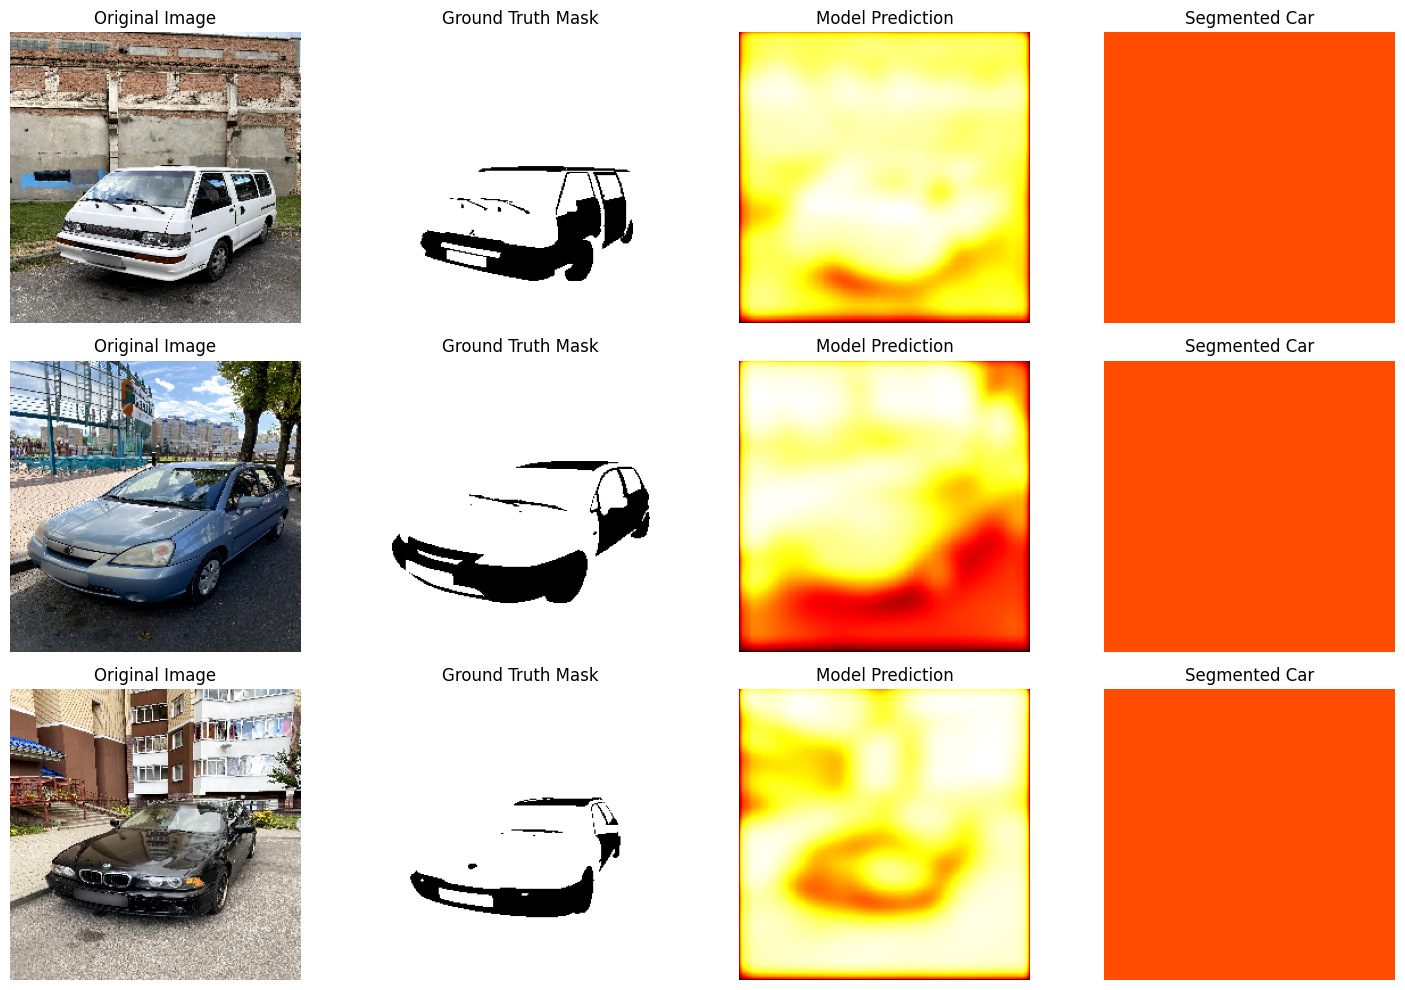

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


IOU Score: 0.9049
Model saved successfully


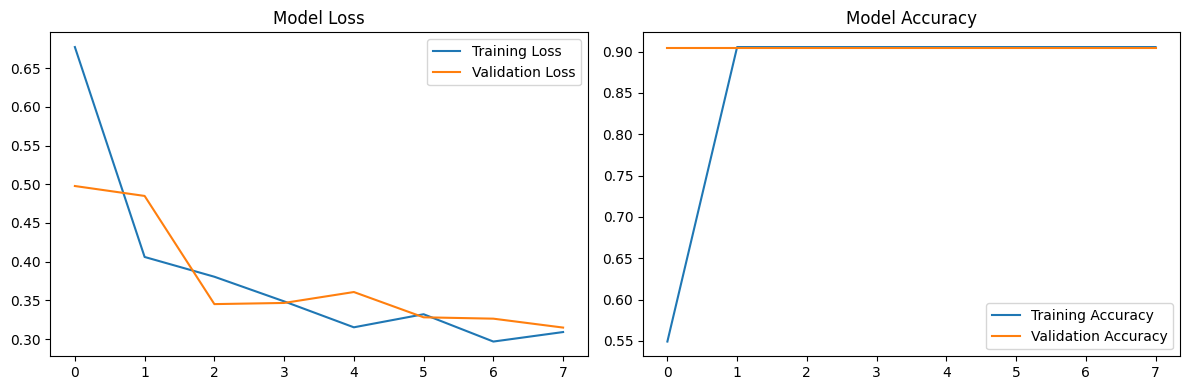

In [2]:

import numpy as np
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

def prepare_car_dataset():
    """
    Load and preprocess car images and segmentation masks
    """
    data_path = r'C:\Users\Public\cars\cars'
    images = []
    masks = []
    images_dir = os.path.join(data_path, 'images')
    masks_dir = os.path.join(data_path, 'masks')
    
    # Count images
    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    print(f'Images prepared: {len(image_files)}')
    
    # Count masks
    mask_files = [f for f in os.listdir(masks_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    print(f'Masks prepared: {len(mask_files)}')
    
    # Match each image with corresponding mask
    for img_file in image_files:
        img_path = os.path.join(images_dir, img_file)
        base_name = os.path.splitext(img_file)[0]
        
        # Find mask with same base name
        possible_masks = [m for m in os.listdir(masks_dir) if base_name in m and m.lower().endswith('.png')]
        if not possible_masks:
            print(f"No mask found for image: {img_file}")
            continue
            
        mask_path = os.path.join(masks_dir, possible_masks[0])
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None or mask is None:
            print(f"Error reading image or mask: {img_file}")
            continue

        # Preprocess image and mask
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        img = img.astype(np.float32) / 255.0
        
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 128).astype(np.float32)
        mask = mask.reshape(256, 256, 1)
        
        images.append(img)
        masks.append(mask)
    
    print(f'Processed images: {len(images)}')
    print(f'Processed masks: {len(masks)}')
    
    if len(images) == 0 or len(masks) == 0:
        print("No data found. Check path and image files.")
        return np.array(images), np.array(masks)
    
    return np.array(images), np.array(masks)

def build_car_model():
    """
    Build CNN model for car segmentation with encoder-decoder architecture
    """
    model = keras.Sequential([
        # Encoder
        keras.layers.Input(shape=(256, 256, 3)),
        keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(2),
        
        keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(2),
        
        keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(2),
        
        # Decoder from encoder
        keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        keras.layers.UpSampling2D(2),
        
        keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        keras.layers.UpSampling2D(2),
        
        keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        keras.layers.UpSampling2D(2),
        
        keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        keras.layers.Conv2D(1, 1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model

def split_data(images, masks, test_size=0.2):
    """
    Split data into training and testing sets
    """
    num_samples = len(images)
    num_test = int(num_samples * test_size)
    indices = np.random.permutation(num_samples)
    
    test_indices = indices[:num_test]
    train_indices = indices[num_test:]
    
    X_train = images[train_indices]
    X_test = images[test_indices]
    y_train = masks[train_indices]
    y_test = masks[test_indices]
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    return X_train, X_test, y_train, y_test

def show_car_results(images, masks, model):
    """
    Visualize original images, masks, and predictions
    """
    indices = np.random.choice(len(images), min(3, len(images)), replace=False)
    
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(indices):
        # Original image
        plt.subplot(3, 4, i*4 + 1)
        plt.imshow(images[idx])
        plt.title('Original Image')
        plt.axis('off')
        
        # Ground truth mask
        plt.subplot(3, 4, i*4 + 2)
        plt.imshow(masks[idx].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        # Model prediction
        plt.subplot(3, 4, i*4 + 3)
        pred = model.predict(images[idx:idx+1], verbose=0)[0]
        plt.imshow(pred.squeeze(), cmap='hot')
        plt.title('Model Prediction')
        plt.axis('off')
        
        # Overlay result
        plt.subplot(3, 4, i*4 + 4)
        result = images[idx].copy()
        mask_pred = pred.squeeze() > 0.5
        result[mask_pred] = [1, 0.3, 0]
        plt.imshow(result)
        plt.title('Segmented Car')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def calculate_iou(y_true, y_pred):
    """
    Calculate Intersection over Union metric
    """
    y_pred = y_pred > 0.5
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def main():
    """
    Main training pipeline
    """
    images, masks = prepare_car_dataset()
    if len(images) == 0 or len(masks) == 0:
        print("No data available. Check dataset path.")
        return
    
    X_train, X_test, y_train, y_test = split_data(images, masks, test_size=0.2)
    
    print(f"Training data: {len(X_train)} samples")
    print(f"Testing data: {len(X_test)} samples")
    
    model = build_car_model()
    print("Model built successfully")
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        epochs=8,
        batch_size=8,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=[early_stopping]
    )
    
    show_car_results(X_test, y_test, model)
    
    predictions = model.predict(X_test)
    iou_score = calculate_iou(y_test, predictions)
    print(f'IOU Score: {iou_score:.4f}')
    
    model.save('car_segmentation_model.h5')
    print("Model saved successfully")
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()
